In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


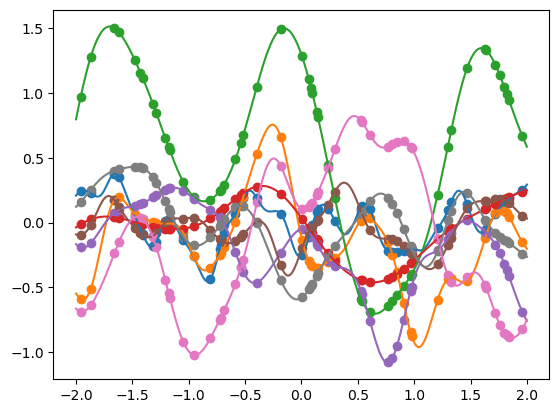

In [6]:
from data.gpdata import GPData
import matplotlib.pyplot as plt

sine_data_test = GPData(max_num_context=97, sigma_noise=5e-5)

batch = sine_data_test.generate_batch(batch_size=8, testing=True, device='cpu')

for i in range(8):
    x_target = batch.x_target[i].flatten()
    y_target = batch.y_target[i].flatten()
    plt.plot(x_target.numpy(), y_target.numpy())
for i in range(8):
    x_context = batch.x_context[i].flatten()
    y_context = batch.y_context[i].flatten()
    plt.scatter(x_context.numpy(), y_context.numpy())
plt.show()

NeuralProcess(
  (latent_encoder): LatentEncoder(
    (phi): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU()
        (4): Linear(in_features=50, out_features=50, bias=True)
        (5): Identity()
      )
    )
    (rho): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=100, bias=True)
        (3): Identity()
      )
    )
  )
  (decoder): Decoder(
    (target_transform): Linear(in_features=1, out_features=50, bias=True)
    (decoder): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=100, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU()
        (4): Linear(in_features=50, out_features=50, bias=True)
        (5): ReLU()

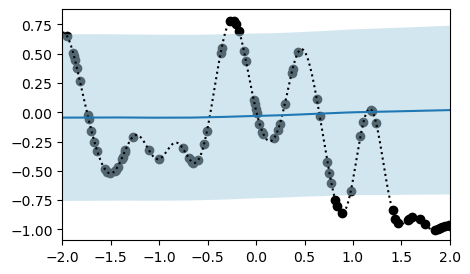

iter 1001: Avg. Loss = 50.3394867041111
iter. loss = 70.07107543945312, iter. Loss2 (not being backpropped on) = 0.7299070358276367
iter 2001: Avg. Loss = 39.03064408826828
iter. loss = 35.179134368896484, iter. Loss2 (not being backpropped on) = 0.4238450229167938
iter 3001: Avg. Loss = 38.02427710574865
iter. loss = 45.032371520996094, iter. Loss2 (not being backpropped on) = 0.6254495978355408
iter 4001: Avg. Loss = 37.2973304054141
iter. loss = 41.875892639160156, iter. Loss2 (not being backpropped on) = 0.5509985685348511
iter 5001: Avg. Loss = 37.71304547810554
iter. loss = 38.33225631713867, iter. Loss2 (not being backpropped on) = 0.5323925018310547
iter 6001: Avg. Loss = 37.051210780858995
iter. loss = 29.833845138549805, iter. Loss2 (not being backpropped on) = 0.5143766403198242
iter 7001: Avg. Loss = 37.45140153956413
iter. loss = 64.73844909667969, iter. Loss2 (not being backpropped on) = 0.7356641292572021
iter 8001: Avg. Loss = 36.83566483032703
iter. loss = 34.420539855

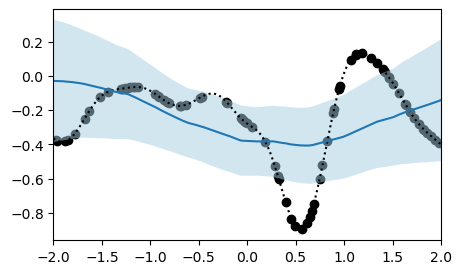

iter 21001: Avg. Loss = 28.113666104972364
iter. loss = 23.190832138061523, iter. Loss2 (not being backpropped on) = 0.45472222566604614
iter 22001: Avg. Loss = 25.452167313098908
iter. loss = 13.570084571838379, iter. Loss2 (not being backpropped on) = 0.3309776484966278
iter 23001: Avg. Loss = 22.519028046756983
iter. loss = 33.092899322509766, iter. Loss2 (not being backpropped on) = 0.3803781569004059
iter 24001: Avg. Loss = 22.17610142055154
iter. loss = 14.275952339172363, iter. Loss2 (not being backpropped on) = 0.2302572876214981
iter 25001: Avg. Loss = 21.086512531414627
iter. loss = -7.592780590057373, iter. Loss2 (not being backpropped on) = -0.09039025008678436
iter 26001: Avg. Loss = 20.980186178848147
iter. loss = 10.824447631835938, iter. Loss2 (not being backpropped on) = 0.1568760722875595
iter 27001: Avg. Loss = 19.9642416780293
iter. loss = 32.38351058959961, iter. Loss2 (not being backpropped on) = 0.3445054590702057
iter 28001: Avg. Loss = 19.84841330422461
iter. l

KeyboardInterrupt: 

In [16]:
import torch
from src.plot import plot_predictive
from src.np import NeuralProcess

x_dim = 1
y_dim = 1
determ_dim = 50  # Dimension of representation of context points
latent_dim = 50  # Dimension of sampled latent variable
hidden_dim = 50  # Dimension of hidden layers in encoder and decoder
np = NeuralProcess(x_dim=x_dim,
                   y_dim=y_dim,
                   hidden_dim=hidden_dim,
                   latent_dim=latent_dim,
                   determ_dim=determ_dim,
                   n_h_layers_decoder=3,
                   n_h_layers_phi_latent_encoder=2,
                   n_h_layers_rho_latent_encoder=1,
                   n_h_layers_phi_determ_encoder=6,
                   n_h_layers_rho_determ_encoder=0,
                   use_deterministic_path=False)
print(np)
print(sum(p.numel() for p in np.parameters() if p.requires_grad))

#data = SineData(max_num_context=30, random_kernel_parameters=True)
optimiser = torch.optim.Adam(np.parameters(), lr=3e-4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
np.to(device)


data = GPData(max_num_context=97)
train_loss = []
avg_loss_fast = 0
avg_loss_slow = 0
for iter in range(100000+1):
    np.training = True
    optimiser.zero_grad()

    batch = data.generate_batch(batch_size=16, device=device)
    p_y_pred, loss, loss2 = np(batch.x_context, batch.y_context, batch.x_target, batch.y_target)

    loss.backward()
    optimiser.step()
    train_loss.append(loss.item())

    avg_loss_slow += loss.item()
    avg_loss_fast += loss.item()
    
    if iter % 1000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss = {avg_loss_fast/1000}")
        print(f"iter. loss = {loss.item()}, iter. Loss2 (not being backpropped on) = {loss2.item()}")
        avg_loss_fast = 0 
    if iter % 10000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss SLOW = {avg_loss_slow/1000}")
        avg_loss_slow = 0 
    if iter % 20000 == 0:
        np.training = False
        batch = data.generate_batch(batch_size=1, testing=True, device=np.device)
        plot_predictive(np, batch, knowledge=None, save=False, iter=None)
        np.training = True

plt.plot(train_loss, label='train_loss')
window = 50
plt.plot([sum(train_loss[i:i+window])/window for i in range(len(train_loss)-window)], label=f'train_loss_{window}_smooth')
plt.legend()
plt.show()